# Using **solt** for instance and semantic segmentation 

In this tutorial, we will shortly demonstrate how to use **solt** in instance and semenatic segmentation tasks.

To run this notebook, please download train images from Kaggle Data Science Bowl'18 page, and place them into **`Data/ds_bowl18_stage_1_train`**.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
import os
import glob
import json

np.random.seed(12345)

In [2]:
import solt.transforms as slt
import solt.core as slc
import solt.data as sld

In [3]:
def get_masks(img_fname):
    img_id = img_fname.split(os.path.sep)[2]
    masks_fnames = glob.glob(os.path.join('Data', 'ds_bowl18_stage_1_train',img_id, 'masks', '*.png'))
    masks = []
    for msk_fname in masks_fnames:
        masks.append(cv2.imread(msk_fname, 0))
    return masks

def vis_img_instances(img, masks):
    m = np.zeros((masks[0].shape), dtype=int)
    for j, msk in enumerate(masks):
        m[msk == 255]=(j+1)

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img)
    ax.imshow(np.ma.masked_array(m, m==0), cmap='nipy_spectral', alpha=0.8)
    plt.show()

## Loading the data

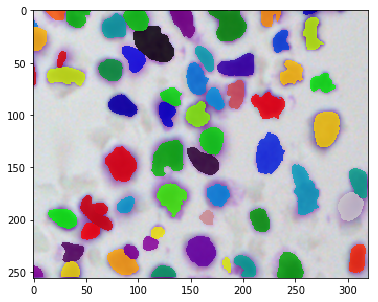

In [4]:
imgs_fnames = glob.glob(os.path.join('Data', 'ds_bowl18_stage_1_train','*', 'images', '*.png'))
fname = imgs_fnames[110]
masks = get_masks(fname)
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
vis_img_instances(img, masks)

## Defining a pipeline

In case if we want to augment every instance for such models as Mask-RCNN, we easily do it using a DataContainer

In [5]:
stream = slc.Stream([
    slt.RandomRotate(rotation_range=(-90, 90), p=1, interpolation='bicubic'),
    slt.PadTransform(200),
    slt.CropTransform(200, crop_mode='c'),
    slt.CropTransform(192, crop_mode='r')
])
print(json.dumps(stream.serialize(), indent=4))

{
    "RandomRotate": {
        "indices": null,
        "interpolation": [
            "bicubic",
            "inherit"
        ],
        "p": 1,
        "padding": [
            "z",
            "inherit"
        ],
        "range": [
            -90,
            90
        ]
    },
    "PadTransform": {
        "indices": null,
        "p": 1,
        "padding": [
            "z",
            "inherit"
        ],
        "to": [
            200,
            200
        ]
    },
    "CropTransform": {
        "indices": null,
        "mode": "r",
        "p": 1,
        "size": [
            192,
            192
        ]
    }
}


## Augmentation results
In the example below, we use all the masks in the augmentation process because of the instance segmentation problem. In case of semantic segmentation, your DataContainer will simply have one image and one mask.

In [6]:
dc = sld.DataContainer(tuple([img,] + masks), 'I'+'M'*len(masks))

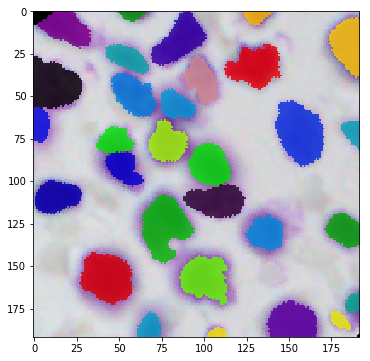

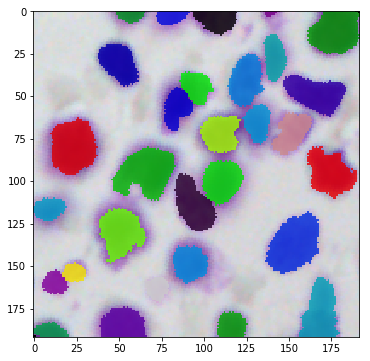

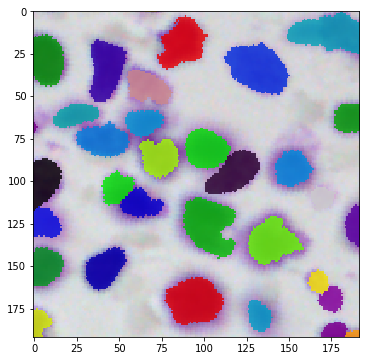

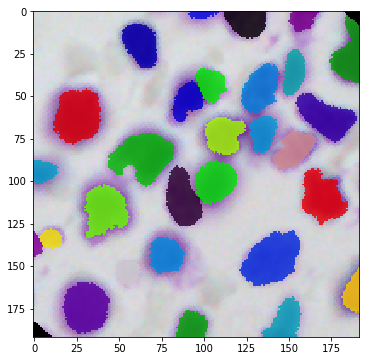

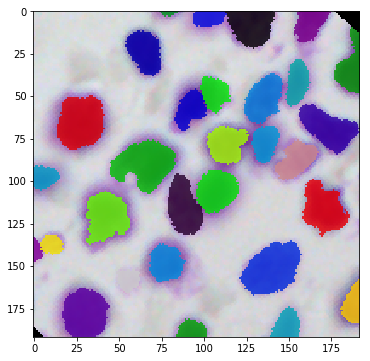

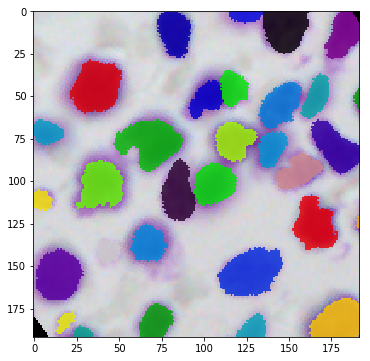

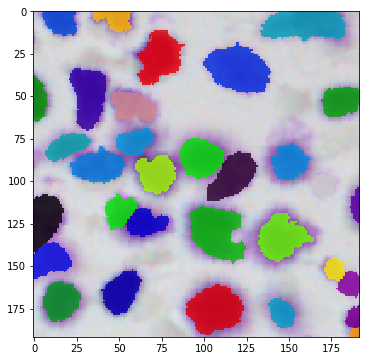

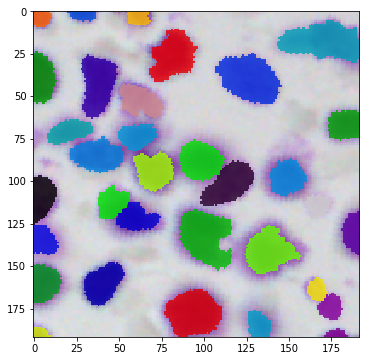

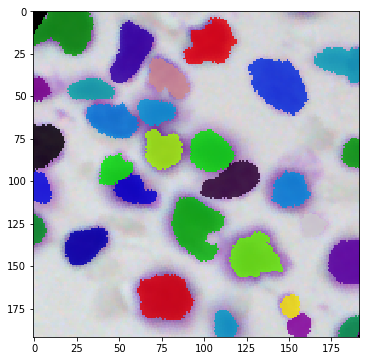

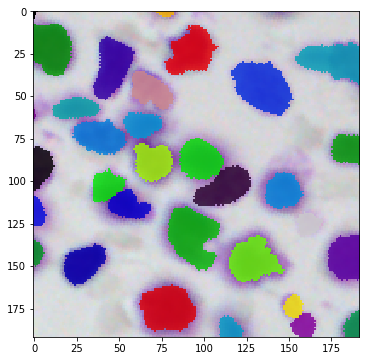

In [7]:
for i in range(10):
    res_dc = stream(dc)
    img_res = res_dc.data[0]
    masks_res = res_dc.data[1:]
    vis_img_instances(img_res, masks_res)